# 寻找特征

In [1]:
import os
import pandas as pd
data_folder = os.path.join(".", "data")
adult_filename = os.path.join(data_folder, "adult.data")

In [2]:
adult = pd.read_csv(adult_filename, header=None, names=["Age", "Work-Class", "fnlwgt", "Education",
                                                        "Education-Num", "Marital-Status", "Occupation",
                                                        "Relationship", "Race", "Sex", "Capital-gain",
                                                        "Capital-loss", "Hours-per-week", "Native-Country",
                                                        "Earnings-Raw"])

In [3]:
adult.dropna(how='all', inplace=True)
adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

In [4]:
adult["Hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours-per-week, dtype: float64

In [5]:
adult["Education-Num"].median()

10.0

In [6]:
adult["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'], dtype=object)

In [7]:
import numpy as np
X = np.arange(30).reshape((10, 3))
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29]])

In [8]:
X[:,1] = 1
X

array([[ 0,  1,  2],
       [ 3,  1,  5],
       [ 6,  1,  8],
       [ 9,  1, 11],
       [12,  1, 14],
       [15,  1, 17],
       [18,  1, 20],
       [21,  1, 23],
       [24,  1, 26],
       [27,  1, 29]])

In [9]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold()
Xt = vt.fit_transform(X)
print(Xt)
print(vt.variances_)

[[ 0  2]
 [ 3  5]
 [ 6  8]
 [ 9 11]
 [12 14]
 [15 17]
 [18 20]
 [21 23]
 [24 26]
 [27 29]]
[ 74.25   0.    74.25]


In [10]:
X = adult[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values
y = (adult["Earnings-Raw"] == ' >50K').values

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print(X)
transformer = SelectKBest(score_func=chi2, k=3)
Xt_chi2 = transformer.fit_transform(X, y)
print(transformer.scores_)

[[   39    13  2174     0    40]
 [   50    13     0     0    13]
 [   38     9     0     0    40]
 ..., 
 [   58     9     0     0    40]
 [   22     9     0     0    20]
 [   52     9 15024     0    40]]
[  8.60061182e+03   2.40142178e+03   8.21924671e+07   1.37214589e+06
   6.47640900e+03]


In [12]:
from scipy.stats import pearsonr

def multivariate_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

In [13]:
transformer = SelectKBest(score_func=multivariate_pearsonr, k=3)
Xt_pearson = transformer.fit_transform(X, y)
print(transformer.scores_)

[ 0.2340371   0.33515395  0.22332882  0.15052631  0.22968907]


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores_chi2 = cross_val_score(clf, Xt_chi2, y, scoring='accuracy')
scores_pearson = cross_val_score(clf, Xt_pearson, y, scoring='accuracy')

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
print("Chi2 performance: {0:.3f}".format(scores_chi2.mean()))
print("Pearson performance: {0:.3f}".format(scores_pearson.mean()))

Chi2 performance: 0.829
Pearson performance: 0.771


# 创造特征

In [16]:
import os
import pandas as pd
import numpy as np
data_folder = os.path.join(".", "data")
data_filename = os.path.join(data_folder, "ad.data")

def convert_number(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

from collections import defaultdict
converters = defaultdict(convert_number)  #{i: convert_number for i in range(1558)}
converters[1558] = lambda x: 1 if x.strip() == "ad." else 0
    
ads = pd.read_csv(data_filename, header=None, converters=converters)
# ads = ads.applymap(lambda x: np.nan if isinstance(x, str) and not x == "ad." else x)
# ads[[0, 1, 2]] = ads[[0, 1, 2]].astype(float)

ads = ads.apply(pd.to_numeric, errors='coerce')
ads = ads.astype(float).dropna()
print(ads[:5])

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


    0      1       2     3     4     5     6     7     8     9     ...   1549  \
0  125.0  125.0  1.0000   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1   57.0  468.0  8.2105   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2   33.0  230.0  6.9696   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3   60.0  468.0  7.8000   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4   60.0  468.0  7.8000   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   1550  1551  1552  1553  1554  1555  1556  1557  1558  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  

[5 rows x 1559 columns]


In [17]:
# ads = ads.astype(float).dropna()
X = ads.drop(1558, axis=1).values
y = ads[1558]
print(X.shape,y.shape)
print(X)


(2359, 1558) (2359,)
[[ 125.      125.        1.     ...,    0.        0.        0.    ]
 [  57.      468.        8.2105 ...,    0.        0.        0.    ]
 [  33.      230.        6.9696 ...,    0.        0.        0.    ]
 ..., 
 [ 101.      140.        1.3861 ...,    0.        0.        0.    ]
 [  23.      120.        5.2173 ...,    0.        0.        0.    ]
 [  40.       40.        1.     ...,    0.        0.        0.    ]]


In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Xd = pca.fit_transform(X)
print(Xd.shape)

(2359, 5)


In [19]:
np.set_printoptions(precision=3, suppress=True)
pca.explained_variance_ratio_

array([ 0.854,  0.145,  0.001,  0.   ,  0.   ])

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X, y, scoring='accuracy')
print("The average score is {:.4f}".format(np.mean(scores)))

The average score is 0.9334


In [21]:
pca.components_[0]

array([ 0.092,  0.995,  0.024, ...,  0.   ,  0.   ,  0.   ])

In [22]:
clf = DecisionTreeClassifier(random_state=14)
scores_reduced = cross_val_score(clf, Xd, y, scoring='accuracy')
print("The average score from the reduced dataset is {:.4f}".format(np.mean(scores_reduced)))

The average score from the reduced dataset is 0.9326


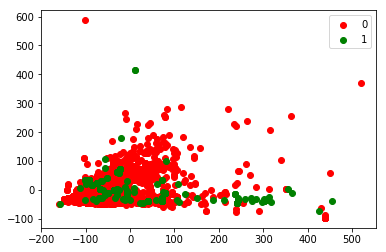

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
classes = set(y)
colors = ['red', 'green']
for cur_class, color in zip(classes, colors):
    mask = (y == cur_class).values
    plt.scatter(Xd[mask,0], Xd[mask,1], marker='o', color=color, label=int(cur_class))
plt.legend()

plt.show()

# 创造自己的转换器

In [24]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array

class MeanDiscrete(TransformerMixin):
    def fit(self, X, y=None):
        X = as_float_array(X)
        self.mean = np.mean(X, axis=0)
        return self

    def transform(self, X):
        X = as_float_array(X)
        assert X.shape[1] == self.mean.shape[0]
        return X > self.mean

In [25]:
mean_discrete = MeanDiscrete()

X_mean = mean_discrete.fit_transform(X)

In [28]:
#%%file ./data/adult_tests.py
import numpy as np
from numpy.testing import assert_array_equal

def test_meandiscrete():
    X_test = np.array([[ 0,  2],
                        [ 3,  5],
                        [ 6,  8],
                        [ 9, 11],
                        [12, 14],
                        [15, 17],
                        [18, 20],
                        [21, 23],
                        [24, 26],
                        [27, 29]])
    mean_discrete = MeanDiscrete()
    mean_discrete.fit(X_test)
    assert_array_equal(mean_discrete.mean, np.array([13.5, 15.5]))
    X_transformed = mean_discrete.transform(X_test)
    X_expected = np.array([[ 0,  0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1]])
    assert_array_equal(X_transformed, X_expected)

In [29]:
test_meandiscrete()

In [30]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('mean_discrete', MeanDiscrete()),
                     ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, X, y, scoring='accuracy')

In [31]:
print("Mean Discrete performance: {0:.3f}".format(scores_mean_discrete.mean()))

Mean Discrete performance: 0.917
